## Overview

This notebook enables tracking the performance of several mice across sessions for a set of behavioral parameters.

### Prerequisites

- The behavioral parameters must be saved in pickle files during the processing of foraging sessions with `Behavior_Analysis.ipynb`.

### Structure

This notebook is based on two main components:
1. **Data Loading**: Loads specified data from pickle files across sessions and animals using the `load_pickle_data` function, returning a data dictionary.
2. **Plot Generation**: Generates plots to visualize the performance metrics using the data dictionary


In [60]:
import os
import pickle
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt #Creation de graphiques et de visualisations comme matlab
from matplotlib.patches import Polygon #Creation de graphiques et de visualisations comme matlab
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from scipy.ndimage import gaussian_filter as smooth
import gc
import glob
import traject_time
from behavior_analysis_functions import list_sessions_analyzed, \
                                    process_session, html_mouse, load_data, MOUSE_STRING


In [2]:
# the path_to_data_folder is the path of the folder where you store your different mice.

# Windows:
# path_to_data_folder='C:'+os.sep+'Users'+os.sep+'MORVAN'+os.sep+'Documents'+os.sep+'patchouris'+os.sep+'Sample_Data'+os.sep
# Linux:
# path_to_data_folder '/home/david/Documents/Code/ForagingProject/Patchouris/patchouris/Sample_Data/'
# MacOs
# path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/'

path_to_data_folder='/home/david/Documents/David/Data/'

#path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/'

# List all mice in the data folder (If you want to process all the mice in your data folder),
mice_list = [os.path.basename(path) for path in glob.glob(path_to_data_folder + "/MOU*")]
mice_list=sorted(mice_list)
print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder:')


#If you want to process a subset of mice uncomment the line below and comment the 2 lines above

#mice_list: list[str] = ["MOU2334"]  # For processing  a single mice. Equivalent to mice_list = ["MOU2334"] but more correct as it forces to create a list of string
mice_list=['MOU2329', 'MOU2330', 'MOU2331', 'MOU2332', 'MOU2333', 'MOU2334']
#print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder:')

session_list = {}
for mouse in mice_list:
    mouse_folder = path_to_data_folder + mouse
    session_list[mouse] = [name for name in os.listdir(mouse_folder)
                           if os.path.isdir(os.path.join(mouse_folder, name))
                           and name.startswith('MOU')]
    nb_sessions = len(session_list[mouse])
    print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions:')
    print(session_list[mouse], '\n')








Found 6 mice in the data folder:
Hello, I'm MOU2329! I have foraged for 24 sessions:
['MOU2329_20240613-0914', 'MOU2329_20240610-1336', 'MOU2329_20240613-1405', 'MOU2329_20240617-0829', 'MOU2329_20240624-0832', 'MOU2329_20240619-0828', 'MOU2329_20240612-0918', 'MOU2329_20240618-1451', 'MOU2329_20240618-0829', 'MOU2329_20240621-0829', 'MOU2329_20240614-0820', 'MOU2329_20240620-1339', 'MOU2329_20240617-1420', 'MOU2329_20240620-0821', 'MOU2329_20240611-0915', 'MOU2329_20240610-0936', 'MOU2329_20240607-1315', 'MOU2329_20240607-1714', 'MOU2329_20240619-1406', 'MOU2329_20240611-1324', 'MOU2329_20240624-1420', 'MOU2329_20240614-1331', 'MOU2329_20240621-1425', 'MOU2329_20240612-1341'] 

Hello, I'm MOU2330! I have foraged for 24 sessions:
['MOU2330_20240617-0848', 'MOU2330_20240613-0933', 'MOU2330_20240617-1438', 'MOU2330_20240620-1357', 'MOU2330_20240619-0846', 'MOU2330_20240621-0848', 'MOU2330_20240619-1424', 'MOU2330_20240620-0838', 'MOU2330_20240607-1733', 'MOU2330_20240624-1439', 'MOU2330_

In [105]:
def trapezes_from_patch(patch, width):
    """
    generate the trapezes coordinates surrounding a patch
    inputs:
    patch - coordinates of a patch [[Xa, Ya], [Xb, Yb], [Xc, Yc], [Xd, Yd]]
    width - width of the trapeze in pixels
    outputs:
    coordinates [[Xa, Ya], [Xb, Yb], [Xc, Yc], [Xd, Yd]] for the 4 trapezes.
    
    trapezes_from_patch(SWpatch_coords, 200)
    """

    N = [patch[0], patch[1], [patch[1][0]+width, patch[1][1]+width], [patch[0][0]-width, patch[0][1]+width]]
    E = [patch[1], patch[2], [patch[2][0]+width, patch[2][1]-width], [patch[1][0]+width, patch[1][1]+width]]
    S = [patch[2], patch[3], [patch[3][0]-width, patch[3][1]-width], [patch[2][0]+width, patch[2][1]-width]]
    W = [patch[3], patch[0], [patch[0][0]-width, patch[0][1]+width], [patch[3][0]-width, patch[3][1]-width]]
    return N, E, S, W


RESOLUTION = 512, 512
TRAPEZE_SIZE = 35 #how much to extend outside of the objects to detect the trajectories
NWpatch_coords = [[104, RESOLUTION[1] -  125], [173, RESOLUTION[1] -  125], [173, RESOLUTION[1] -  201], [104, RESOLUTION[1] -  201]]
NEpatch_coords = [[330, RESOLUTION[1] -  120], [400, RESOLUTION[1] -  120], [400, RESOLUTION[1] -  200], [330, RESOLUTION[1] -  200]]
SWpatch_coords = [[109, RESOLUTION[1] -  351], [181, RESOLUTION[1] -  351], [181, RESOLUTION[1] -  410], [109, RESOLUTION[1] -  410]]
SEpatch_coords = [[330, RESOLUTION[1] -  350], [400, RESOLUTION[1] -  350], [400, RESOLUTION[1] -  410], [330, RESOLUTION[1] -  410]]

collection_trapeze = {"NW":dict(), "NE":dict(), "SW":dict(), "SE":dict()}
collection_trapeze["NW"]["N"], collection_trapeze["NW"]["E"], collection_trapeze["NW"]["S"], collection_trapeze["NW"]["W"] = trapezes_from_patch(NWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["NE"]["N"], collection_trapeze["NE"]["E"], collection_trapeze["NE"]["S"], collection_trapeze["NE"]["W"] = trapezes_from_patch(NEpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SW"]["N"], collection_trapeze["SW"]["E"], collection_trapeze["SW"]["S"], collection_trapeze["SW"]["W"] = trapezes_from_patch(SWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SE"]["N"], collection_trapeze["SE"]["E"], collection_trapeze["SE"]["S"], collection_trapeze["SE"]["W"] = trapezes_from_patch(SEpatch_coords, TRAPEZE_SIZE)

## Playing with other movements stored in all_running_epochs.pkl

In [14]:
mice_list

['MOU2329', 'MOU2330', 'MOU2331', 'MOU2332', 'MOU2333', 'MOU2334']

In [15]:
session_list

{'MOU2329': ['MOU2329_20240613-0914',
  'MOU2329_20240610-1336',
  'MOU2329_20240613-1405',
  'MOU2329_20240617-0829',
  'MOU2329_20240624-0832',
  'MOU2329_20240619-0828',
  'MOU2329_20240612-0918',
  'MOU2329_20240618-1451',
  'MOU2329_20240618-0829',
  'MOU2329_20240621-0829',
  'MOU2329_20240614-0820',
  'MOU2329_20240620-1339',
  'MOU2329_20240617-1420',
  'MOU2329_20240620-0821',
  'MOU2329_20240611-0915',
  'MOU2329_20240610-0936',
  'MOU2329_20240607-1315',
  'MOU2329_20240607-1714',
  'MOU2329_20240619-1406',
  'MOU2329_20240611-1324',
  'MOU2329_20240624-1420',
  'MOU2329_20240614-1331',
  'MOU2329_20240621-1425',
  'MOU2329_20240612-1341'],
 'MOU2330': ['MOU2330_20240617-0848',
  'MOU2330_20240613-0933',
  'MOU2330_20240617-1438',
  'MOU2330_20240620-1357',
  'MOU2330_20240619-0846',
  'MOU2330_20240621-0848',
  'MOU2330_20240619-1424',
  'MOU2330_20240620-0838',
  'MOU2330_20240607-1733',
  'MOU2330_20240624-1439',
  'MOU2330_20240614-0840',
  'MOU2330_20240611-0936',
  'MO

In [16]:
path_to_data_folder

'/home/david/Documents/David/Data/'

In [27]:
mouse_folder_path=os.path.join(path_to_data_folder,mice_list[0])
print(mouse_folder_path)

/home/david/Documents/David/Data/MOU2329


In [28]:
print(session_list[mice_list[0]][7])

MOU2329_20240618-1451


In [29]:
traj_df, turns_df, param_df=load_data(mouse_folder_path,session_list[mice_list[0]][7])

In [70]:
# smooth the trajectory and correct for some open CV flipping


TRUE_SIGMA = 1 #the sigma used for the remaining of the analysis for smoothing
traject_time = traj_df['time'].to_numpy()
xposition = traj_df['xposition'].to_numpy()
yposition = traj_df['yposition'].to_numpy()
yposition = RESOLUTION[1] - yposition # yposition is inverted, puts it back in the right way. DAvid: this is not simply an inversion because resolution is added
smoothed_Xposition = smooth(xposition, TRUE_SIGMA)
smoothed_Yposition = smooth(yposition, TRUE_SIGMA) # Smoothes the positions with true sigma

In [40]:
type(smoothed_Xposition)

numpy.ndarray

In [30]:
pathtopicklefolder=os.path.join(mouse_folder_path,session_list[mice_list[0]][7],'Pickle_data')
print(pathtopicklefolder)

/home/david/Documents/David/Data/MOU2329/MOU2329_20240618-1451/Pickle_data


In [31]:
# List all files in the current directory
os.chdir(pathtopicklefolder)
files_in_directory = os.listdir()

# Filter out the pickle files
pickle_files = [file for file in files_in_directory if file.endswith('.pkl')]

# Print the list of pickle files
for pickle_file in pickle_files:
    print(pickle_file)

file_to_load = pickle_files[6]
print(f"\nLoading pickle file: {file_to_load}")

# Open and load the pickle file
with open(file_to_load, 'rb') as f:
    loaded_data = pickle.load(f)

# Print the loaded data to verify
print("\nLoaded data from the pickle file:")
print(loaded_data)

speed_profile_qt.pkl
distance_traveled.pkl
total_nb_CW_CCW.pkl
rewards_cumul.pkl
consecutive_quarter_turns.pkl
cw_ccw_cumul.pkl
all_running_epochs.pkl
total_nb_QT_types.pkl
cw_ccw_speeds.pkl

Loading pickle file: all_running_epochs.pkl

Loaded data from the pickle file:
[[0, 47, 'BSESWn', np.int64(1)], [50, 78, 'QkTSWR', np.int64(1)], [236, 277, 'N', np.int64(2)], [304, 322, 'N', 0], [322, 390, 'N', np.int64(3)], [395, 424, 'TNE', 0], [438, 460, 'QkTNER', np.int64(3)], [462, 487, 'N', np.int64(3)], [534, 555, 'TNE', 0], [594, 626, 'N', np.int64(3)], [633, 705, 'N', np.int64(3)], [706, 724, 'N', 0], [745, 805, 'N', 0], [815, 837, 'N', 0], [932, 1057, 'N', np.int64(6)], [1112, 1148, 'TNE', np.int64(6)], [1150, 1167, 'QkTNER', np.int64(6)], [1174, 1197, 'BNESEn', np.int64(6)], [1200, 1215, 'QwTSER', np.int64(6)], [1225, 1247, 'QwTSER', np.int64(6)], [1292, 1309, 'QwTSER', np.int64(6)], [1312, 1330, 'QwTSER', np.int64(6)], [1332, 1350, 'N', 0], [1377, 1390, 'N', 0], [1391, 1401, 'TNE', np.

In [32]:
list_between_objects = [epoch for epoch in loaded_data if epoch[2][0] == "B"]

In [95]:
list_quarter_turns = [epoch for epoch in loaded_data if epoch[2][0] == "Q"] # All QT
print(list_quarter_turns)

[[50, 78, 'QkTSWR', np.int64(1)], [438, 460, 'QkTNER', np.int64(3)], [1150, 1167, 'QkTNER', np.int64(6)], [1200, 1215, 'QwTSER', np.int64(6)], [1225, 1247, 'QwTSER', np.int64(6)], [1292, 1309, 'QwTSER', np.int64(6)], [1312, 1330, 'QwTSER', np.int64(6)], [2039, 2063, 'QwGNWR', np.int64(10)], [2074, 2099, 'QwGNWR', np.int64(11)], [2114, 2141, 'QwDNWR', np.int64(12)], [2153, 2172, 'QkGNWR', np.int64(12)], [2182, 2199, 'QkDNWR', np.int64(13)], [2223, 2242, 'QkGNWR', np.int64(13)], [2336, 2352, 'QwTNER', np.int64(14)], [2359, 2373, 'QwTNER', np.int64(14)], [2376, 2396, 'QwTNER', np.int64(14)], [2422, 2438, 'QwTNER', np.int64(14)], [2468, 2480, 'QkTNER', np.int64(14)], [2483, 2499, 'QkTNER', np.int64(14)], [2504, 2519, 'QkTNER', np.int64(14)], [2540, 2556, 'QwTNER', np.int64(14)], [2591, 2606, 'QkTSER', np.int64(14)], [2613, 2631, 'QkTSER', np.int64(14)], [2692, 2708, 'QkTNER', np.int64(15)], [2766, 2783, 'QkTNWR', np.int64(15)], [2788, 2806, 'QkTNWR', np.int64(15)], [2886, 2906, 'QkTSWR', n

In [102]:
list_around_towers = [epoch for epoch in loaded_data if epoch[2][0] == "Q"]
list_between_towers = [epoch for epoch in loaded_data if epoch[2][0] == "B"]
list_toward_towers = [epoch for epoch in loaded_data if epoch[2][0] == "T"] # All trajectories towards objects
list_other_movements = [epoch for epoch in loaded_data if epoch[2][0] == "N"] # All other trajectories

In [25]:
list_between_objects[0]

[0, 47, 'BSESWn', np.int64(1)]

In [106]:

def plot_run_type(traject_time, smoothed_Xposition, smoothed_Yposition, list_runtype_epochs, q=4, runtype_name='same type of run'):
    plt.figure(figsize=(10, 8))
    runtype_totaltime = 0

  
    
    for runtype_epoch in list_runtype_epochs:
        start_index, end_index = runtype_epoch[0], runtype_epoch[1]
        
        # Check if the indexes are within the bounds of the arrays
        if start_index < 0 or end_index >= len(traject_time):
            print(f"Indexes out of bounds for runtype_epoch: {runtype_epoch}")
            continue

        # Extract the quarter_turn segment
        runtype_epoch_Xposition = smoothed_Xposition[start_index:end_index + 1]
        runtype_epoch_Yposition = smoothed_Yposition[start_index:end_index + 1]
        epochduration = traject_time[end_index] - traject_time[start_index]
        runtype_totaltime += epochduration

        # Plot the trajectory
        plt.plot(runtype_epoch_Xposition, runtype_epoch_Yposition, linestyle='-', label=f"Traj {start_index}-{end_index}")
        
        # Plot the start and end points
        plt.plot(runtype_epoch_Xposition[0], runtype_epoch_Yposition[0], 'go', markersize=3)  # Start point
        #plt.plot(runtype_epoch_Xposition[-1], runtype_epoch_Yposition[-1], 'ro', markersize=10)  # End point

        # Compute the direction of the arrow using the last q points
        if len(runtype_epoch_Xposition) >= q:
            dx = runtype_epoch_Xposition[-1] - runtype_epoch_Xposition[-q]
            dy = runtype_epoch_Yposition[-1] - runtype_epoch_Yposition[-q]
            
            # Normalize the direction
            norm = np.hypot(dx, dy)
            if norm != 0:
                dx /= norm
                dy /= norm
            
            # Plot the arrow
            plt.arrow(runtype_epoch_Xposition[-1], runtype_epoch_Yposition[-1], dx, dy,
                      head_width=6, head_length=5, fc='red', ec='red')
    
    # Set the title including the total duration
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f"All {runtype_name} (Total Duration: {runtype_totaltime:.2f}s.)")
    plt.grid(True)
    # plt.legend()
    plt.show()




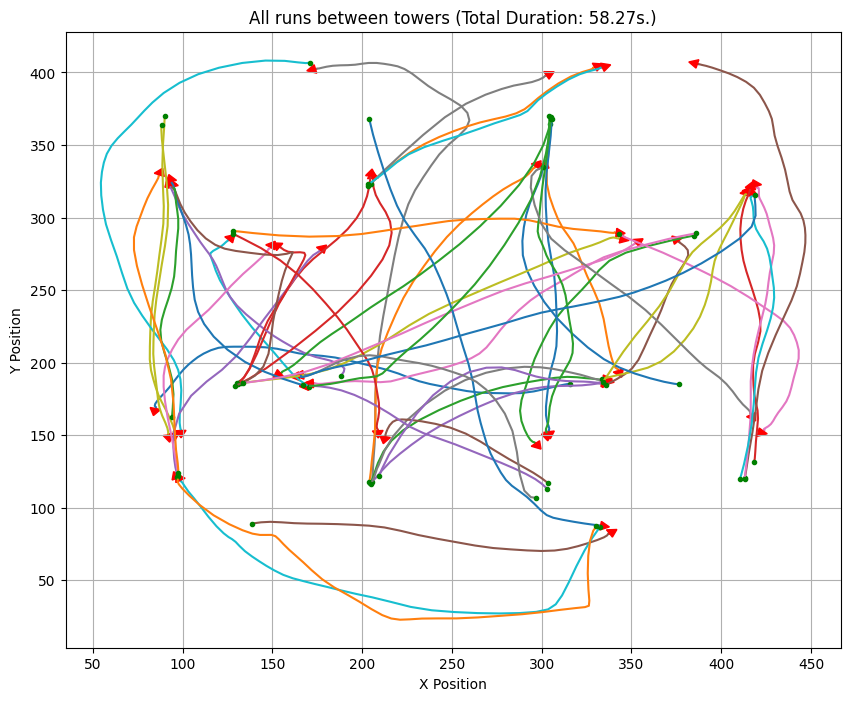

In [107]:

plot_run_type(traject_time, smoothed_Xposition, smoothed_Yposition, list_between_objects,runtype_name='runs between towers', q=4)

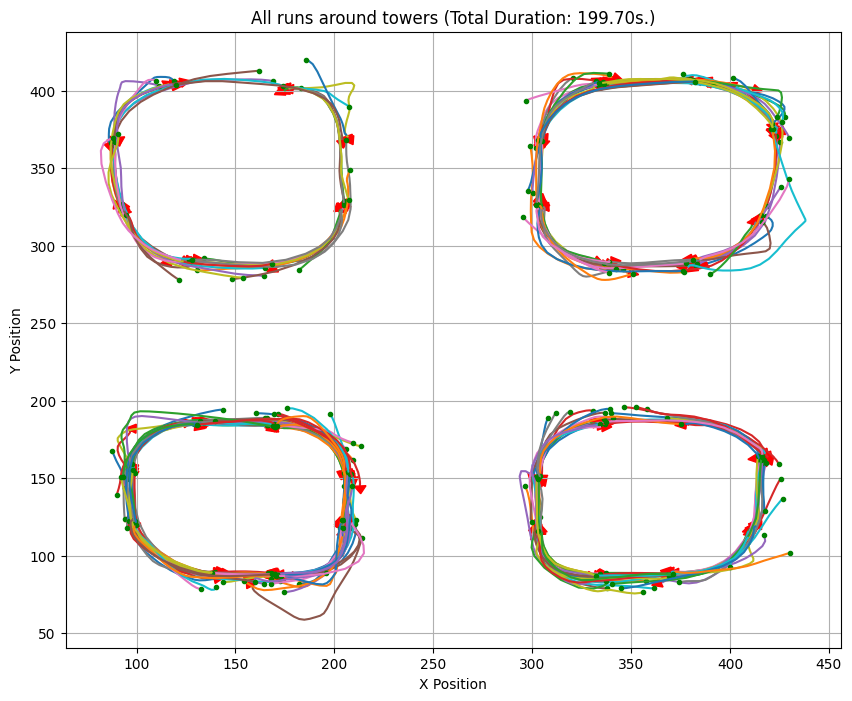

In [96]:

plot_run_type(traject_time, smoothed_Xposition, smoothed_Yposition, list_quarter_turns,runtype_name='runs around towers', q=4)

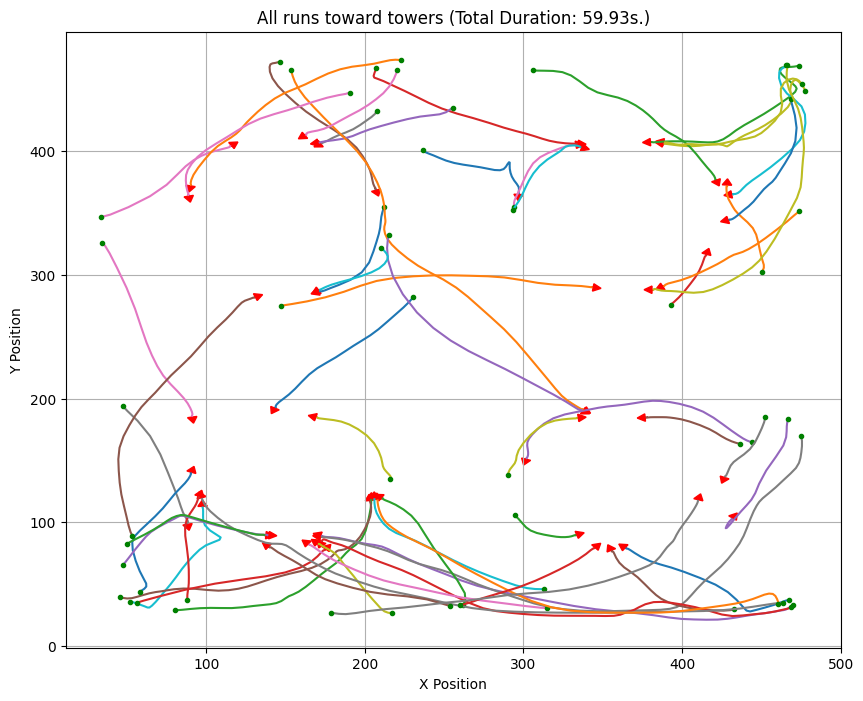

In [101]:

plot_run_type(traject_time, smoothed_Xposition, smoothed_Yposition, list_toward_object,runtype_name='runs toward towers', q=4)

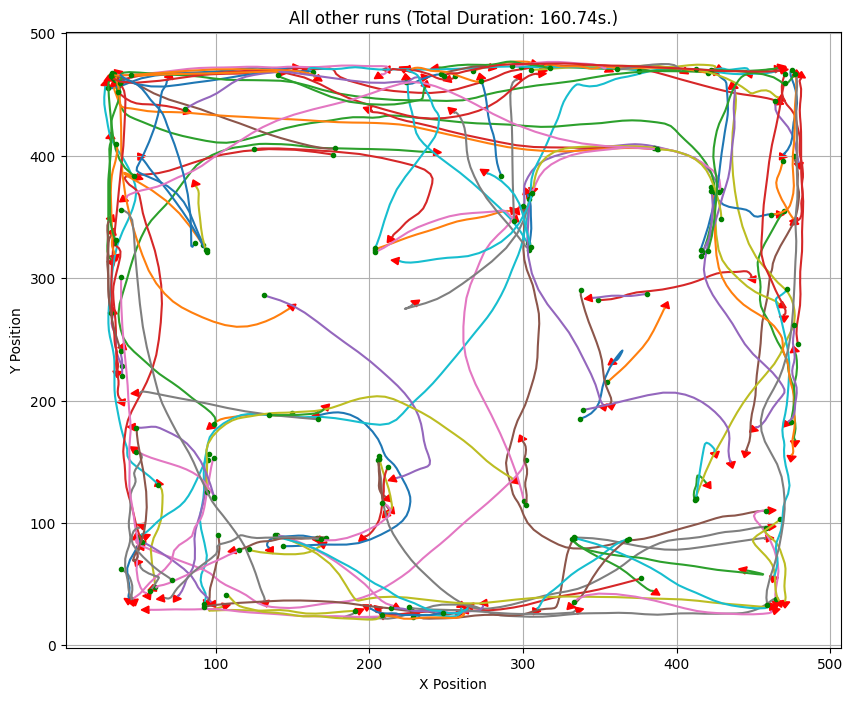

In [104]:

plot_run_type(traject_time, smoothed_Xposition, smoothed_Yposition, list_other_movements,runtype_name='other runs', q=4)

In [111]:
collection_trapeze

{'NW': {'N': [[104, 387], [173, 387], [208, 422], [69, 422]],
  'E': [[173, 387], [173, 311], [208, 276], [208, 422]],
  'S': [[173, 311], [104, 311], [69, 276], [208, 276]],
  'W': [[104, 311], [104, 387], [69, 422], [69, 276]]},
 'NE': {'N': [[330, 392], [400, 392], [435, 427], [295, 427]],
  'E': [[400, 392], [400, 312], [435, 277], [435, 427]],
  'S': [[400, 312], [330, 312], [295, 277], [435, 277]],
  'W': [[330, 312], [330, 392], [295, 427], [295, 277]]},
 'SW': {'N': [[109, 161], [181, 161], [216, 196], [74, 196]],
  'E': [[181, 161], [181, 102], [216, 67], [216, 196]],
  'S': [[181, 102], [109, 102], [74, 67], [216, 67]],
  'W': [[109, 102], [109, 161], [74, 196], [74, 67]]},
 'SE': {'N': [[330, 162], [400, 162], [435, 197], [295, 197]],
  'E': [[400, 162], [400, 102], [435, 67], [435, 197]],
  'S': [[400, 102], [330, 102], [295, 67], [435, 67]],
  'W': [[330, 102], [330, 162], [295, 197], [295, 67]]}}

In [109]:

from matplotlib.patches import Polygon

def plot_run_type(traject_time, smoothed_Xposition, smoothed_Yposition, list_runtype_epochs, collection_trapezea, q=4, runtype_name='same type of run'):
    fig, ax1 = plt.subplots(figsize=(10, 8))
    runtype_totaltime = 0
    
    for patch in collection_trapeze:  # plot the trapeze around the object
        for trapeze in collection_trapeze[patch]:
            shape = Polygon(np.array(collection_trapeze[patch][trapeze]), color="lemonchiffon")
            ax1.add_patch(shape)

    for runtype_epoch in list_runtype_epochs:
        start_index, end_index = runtype_epoch[0], runtype_epoch[1]
        
        # Check if the indexes are within the bounds of the arrays
        if start_index < 0 or end_index >= len(traject_time):
            print(f"Indexes out of bounds for runtype_epoch: {runtype_epoch}")
            continue

        # Extract the quarter_turn segment
        runtype_epoch_Xposition = smoothed_Xposition[start_index:end_index + 1]
        runtype_epoch_Yposition = smoothed_Yposition[start_index:end_index + 1]
        epochduration = traject_time[end_index] - traject_time[start_index]
        runtype_totaltime += epochduration

        # Plot the trajectory
        ax1.plot(runtype_epoch_Xposition, runtype_epoch_Yposition, linestyle='-', label=f"Traj {start_index}-{end_index}")
        
        # Plot the start and end points
        ax1.plot(runtype_epoch_Xposition[0], runtype_epoch_Yposition[0], 'go', markersize=3)  # Start point
        #ax1.plot(runtype_epoch_Xposition[-1], runtype_epoch_Yposition[-1], 'ro', markersize=10)  # End point

        # Compute the direction of the arrow using the last q points
        if len(runtype_epoch_Xposition) >= q:
            dx = runtype_epoch_Xposition[-1] - runtype_epoch_Xposition[-q]
            dy = runtype_epoch_Yposition[-1] - runtype_epoch_Yposition[-q]
            
            # Normalize the direction
            norm = np.hypot(dx, dy)
            if norm != 0:
                dx /= norm
                dy /= norm
            
            # Plot the arrow
            ax1.arrow(runtype_epoch_Xposition[-1], runtype_epoch_Yposition[-1], dx, dy,
                      head_width=6, head_length=5, fc='red', ec='red')
    
    # Set the title including the total duration
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.set_title(f"{runtype_name} (Total Duration: {runtype_totaltime:.2f})")
    ax1.grid(True)
    # ax1.legend()
    plt.show()



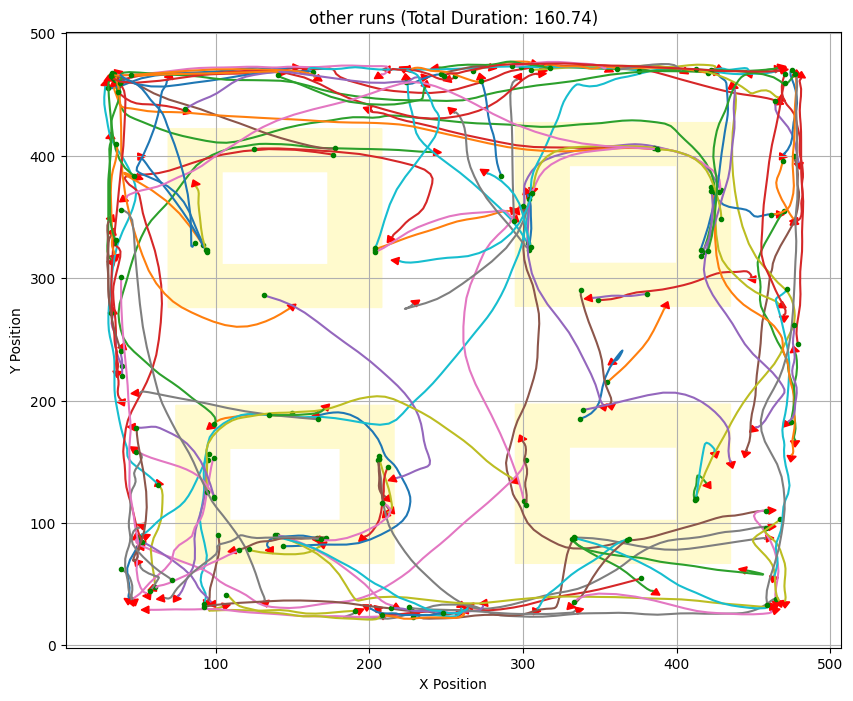

In [112]:

plot_run_type(traject_time, smoothed_Xposition, smoothed_Yposition, list_other_movements,collection_trapeze, runtype_name='other runs', q=4)